# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/maurizio/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.shape, customers.shape

((891221, 366), (191652, 369))

Looks we had some trouble already while importing with some features that have mixed types values

In [3]:
# These two featutres have mixed type float and string
azdias.iloc[:,18:20].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8,51
2,4,24
3,2,12
4,6,43


In [4]:
azdias.CAMEO_DEUG_2015.value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [5]:
azdias.CAMEO_INTL_2015.value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

This shows a problem with this table where there are same values that are different because of the type either int or fload

In [6]:
# Let's fix it straightaway
def fix_cameo (df):
    """
    
    """
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X': np.nan})
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    return df

azdias = fix_cameo(azdias)

So the values X and XX in these two tables are to be considered "unknown" and converted to null. So in our initial cleaning we will check the values of the documented features against the documentation ( the "DIAS Attributes - Values 2017.xlsx" file) and consider the ones that fall outside the ranges provided as null.


In [7]:
# Reading the features description excel file into a Dataframe
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', sheet_name='Tabelle1', index_col=[0, 1, 2]).reset_index()
feat_info.drop('level_0', axis=1, inplace=True)
feat_info_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', index_col=[0, 1]).reset_index()
feat_info_levels.drop('level_0', axis=1, inplace=True) 

feat_info_levels.head()
feat_info[feat_info.Attribute=='CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [8]:
# Turns out the feat_info dataset from the Excel spreadsheet has some columns that are not in the population dataset
# and vicecersa, Let's explore a bit
# These one are in the population and are described in the spreadsheet
attributes_we_have_info_about = np.intersect1d(feat_info.Attribute.unique(), np.array(azdias.columns))
# These one are in the population and are NOT described in the spreadsheet
attributes_we_dont_have_info = np.setdiff1d(np.array(azdias.columns), feat_info.Attribute.unique())
# These one are in the spreadsheet and are NOT in the population so we just ignore them for now
attributes_we_dont_care = np.setdiff1d(feat_info.Attribute.unique(), np.array(azdias.columns))

len(attributes_we_have_info_about), len(attributes_we_dont_have_info), len(attributes_we_dont_care)

(270, 96, 42)

Using the descriptions in the included excel spreadsheet, we will build a azdias_info dataframe where we will also add the type of the feature. Since not all features are included in the spreadsheet, we will have to add those to the dataframe, too.

In [9]:
# We can build a dataframe with atributes and type plus description of unknown values 
unknown_values = ['unknown', 'unknown / no main age detectable', 'no transactions known', 'numeric value (typically coded from 1-10)',
                 'numeric value (typically coded from 1-3)', 'no transaction known']
azdias_info =  feat_info[(feat_info.Attribute.isin(attributes_we_have_info_about)) & (feat_info.Meaning.isin(unknown_values))]
# Add the ones who don't have unknown values

# Add columns that are in the excel spreadhseet but don't have a "unkmown value"
for feat in np.setdiff1d(feat_info.Attribute[attributes_we_have_info_about].index, azdias_info.Attribute):
    azdias_info = azdias_info.append(feat_info[feat_info.Attribute == feat].iloc[0,:2])

# Finally add columns missing if the excel spreadsheet
azdias_info = pd.concat([azdias_info, pd.DataFrame(np.setdiff1d(azdias.columns.values, azdias_info.Attribute), columns=['Attribute'])], sort=False, axis=0)

# Adding a Type column initially setting everything to 'Ordinal' 
azdias_info['Type'] = 'Ordinal'
azdias_info.to_csv('azdias_info.csv')

In [10]:
# Reload dataframe after working on it in Excel
azdias_info = pd.read_csv('azdias_info_reload.csv', index_col=[0])

azdias_info.head()
# The Value column has values that are to be considered nulls

,Attribute,Description,Meaning,Value,Type,Notes
0,AGER_TYP,best-ager typology,unknown,-1,Ordinal,NaN
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,unknown,"-1, 0",Ordinal,NaN
11,ALTER_HH,main age within the household,unknown / no main age detectable,0,Ordinal,NaN
33,ANREDE_KZ,gender,unknown,"-1, 0",Binary,NaN
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,numeric value (typically coded from 1-10),0,Numeric,NaN


In [11]:
print("Our info dataframe \"azdias_info\" has descriptions for {} features out of {}".format(azdias_info.shape[0], azdias.shape[1]))
azdias_info.Type.value_counts()
ordinal_features = azdias_info[azdias_info.Type == 'Ordinal'].Attribute.values
print("Dataset has {} ordinal features".format(len(ordinal_features)))
categorical_features = azdias_info[azdias_info.Type == 'Categorical'].Attribute.values
print("Dataset has {} categorical features".format(len(categorical_features)))
numeric_features = azdias_info[azdias_info.Type == 'Numeric'].Attribute.values
print("Dataset has {} numeric features".format(len(numeric_features)))
binary_features =   azdias_info[azdias_info.Type == 'Binary'].Attribute.values  
print("Dataset has {} binary features".format(len(binary_features)))
# Mix-Type features combine information over 2 axes and will be engineered separately
mix_type_features = azdias_info[azdias_info.Type == 'Mix-Type'].Attribute.values 
print("Dataset has {} Mix-Type features".format(len(mix_type_features)))


Our info dataframe "azdias_info" has descriptions for 366 features out of 366
Dataset has 322 ordinal features
Dataset has 22 categorical features
Dataset has 9 numeric features
Dataset has 8 binary features
Dataset has 5 Mix-Type features


So we will start handling the features that are documented for now and run some cleaning scripts, then we will explore the undocumented ones and decide what to do with them.

In [12]:
# Some utility functions
# split a string is a string otherwise return unchanged
def split_if_string(x):
    """
    
    """
    if isinstance(x, str):
        return x.split(',')
    else:
        return x
# Change ints into floats in a list and leave anything else unchanged
def to_float(x):
    """
    
    """
    try:
        x = float(x)
    except:
        pass
    return x

def is_number(s):
    """
    
    """
    try:
        float(s)
        return True
    except ValueError:
        return False

In [13]:
# Now we will look for "undocumented" null values, that are not included in the spreadsheet

attributes_to_check = np.setdiff1d(attributes_we_have_info_about, numeric_features)

# Better align values first as it is taking as different int and floats

def check_all_values(df, feat_info):
    for attribute in attributes_to_check:
        theoretical_vals = feat_info[feat_info.Attribute == attribute].Value.apply(lambda x: split_if_string(x)).values
        theoretical_vals = np.hstack(theoretical_vals)
        theoretical_vals = [to_float(x) for x in theoretical_vals]
        actual_values = df.loc[:, attribute].value_counts().index.values
        actual_values = [to_float(x) for x in actual_values]
        #diff = set(actual_values) - set(theoretical_vals)
        diff = np.setdiff1d(actual_values, theoretical_vals)
        if diff.size > 0:
            print('Attribute {} has undocumented values {}'.format(attribute, diff))

            
check_all_values(azdias, feat_info)

Attribute CAMEO_DEU_2015 has undocumented values ['XX']
Attribute KBA05_MODTEMP has undocumented values [6.]
Attribute LP_FAMILIE_FEIN has undocumented values [0.]
Attribute LP_FAMILIE_GROB has undocumented values [0.]
Attribute LP_LEBENSPHASE_FEIN has undocumented values [0.]
Attribute LP_LEBENSPHASE_GROB has undocumented values [0.]
Attribute ORTSGR_KLS9 has undocumented values [0.]


So here we have:

CAMEO_DEU_2015: most common building-type within the cell => XX is a null

KBA05_MODTEMP: development of the most common car segment in the neighbourhood: we keep 6.0 although it's not documented

LP_FAMILIE_FEIN: familytyp fine: 0 is a null, must be between 1 to 11

LP_FAMILIE_GROB familytyp rough, must be 1 to 11, so 0 is a null

LP_LEBENSPHASE_FEIN: lifestage fine, must be 1 to 40, so 0 is a null

LP_LEBENSPHASE_GROB: lifestage rough, must be 1 to 12, so 0 is  a null

ORTSGR_KLS9: size of the community, 1 to 9, so 0 is a null


In [14]:
# we can fix those above
def fix_undocumented_nulls(df):
    dxx = {'XX':np.nan}
    d0 = {0:np.nan}
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(dxx)
    df['LP_FAMILIE_FEIN'] = df['LP_FAMILIE_FEIN'].replace(d0)
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].replace(d0)
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace(d0)
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace(d0)
    df['ORTSGR_KLS9'] = df['ORTSGR_KLS9'].replace(d0)
    return df

azdias =  fix_undocumented_nulls(azdias)

Now we will use the dataframe we built with the nformation of whoch values cam be considered null to replace the unlknown values with null.
We leave the features that have a value equal to zero with Meaning "no transaction known"as they represent transactional activity over a period, so we interpret is as "zero transactions".


In [15]:
# Now let's convert the other nulls
import progressbar

def unknown2nulls(df, df_info):
    """
    
    """
    
    n_iters = df_info.shape[0]
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_iters+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for _, info_row in df_info[df_info.Value.notnull()].iterrows():
        #print('Replacing ', info_row.Attribute)
        if isinstance(info_row.Value, str):
            d = {}
            for unknown_value in info_row.Value.split(','):
                d[float(unknown_value)] = np.nan
            df[info_row.Attribute] = df[info_row.Attribute].replace(d)
        else:
            d = {info_row.Value : np.nan}
            df[info_row.Attribute] = df[info_row.Attribute].replace(d)
        cnter+=1 
        bar.update(cnter)
    
    bar.finish()            
    return df

azdias = unknown2nulls(azdias, azdias_info)

[========================================================================] 100%


### Choosing columns to drop
We will analyze the amount of missing data and choose which columns to drop.
Additionally some columns may be dropped for tyher reasons, for example:
- They have all unique values (useless for machine learning)
- Categorical features with high cardinality, for example more than 10-15 categories 
- when we don't have enough information to decide how to encode them
- features that are a possible source of ethical bias

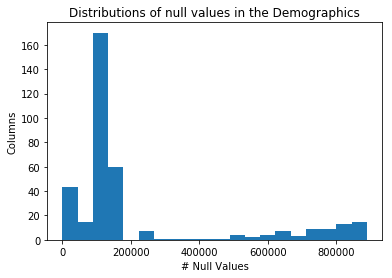

In [16]:
# Assess missing data in columns
plt.hist(azdias.isnull().sum(), bins=20)
plt.title('Distributions of null values in the Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Columns');

The distribution above shows that some outlier features have more than 250,000 null values.

Text(0.5,1,'Attributes with more than 30% of missing values')

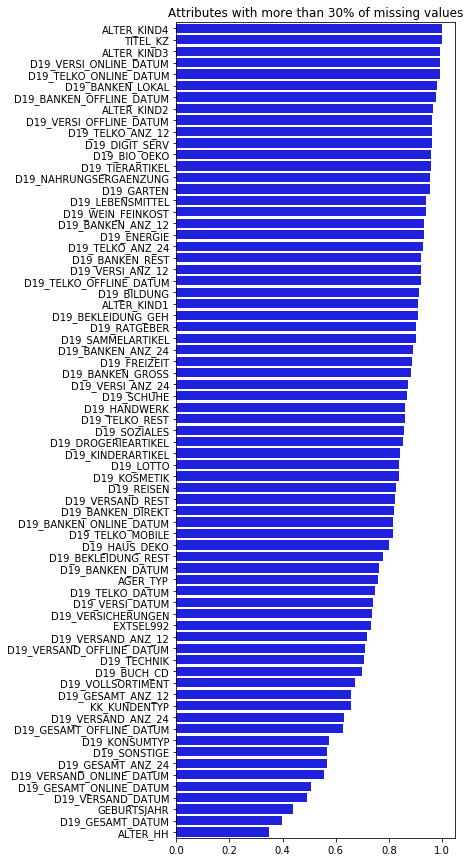

In [17]:
# Investigate patterns in the amount of missing data in each column.
columns = azdias.isnull().sum().sort_values(ascending=False)
percent_missing = columns/azdias.shape[0]
data = percent_missing[percent_missing > 0.3]
plt.figure(figsize=(5,15))
sns.barplot(y=data.index, x=data.values, orient='h', color='blue')
plt.title("Attributes with more than 30% of missing values")

We will now extract a list of the columns to drop. The script will be later run on the customer data set as well, but we won't recalculate the list for the customer dataset. The idea is to use the general population dataset to "fit" our methods, like we will do later on with PCA, KMeans, etc, and then apply the fitted methods to tranform the features of the customer or other datasest. 

In [18]:
# The columns to drop should be the same on population and customer dataset, so we leave it outside the function
columns_to_drop = [s for s, v in (azdias.isnull().sum() > azdias.shape[0] * 0.3).items() if v]
print(columns_to_drop)

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D19_TIERARTIKEL

In [19]:
def drop_columns(df):
    """
    
    """
    columns_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO',
       'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
       'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12',
       'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_REST', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'D19_VERSICHERUNGEN',
       'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'EXTSEL992',
       'GEBURTSJAHR', 'KK_KUNDENTYP', 'TITEL_KZ']
    df = df.drop(columns_to_drop, axis=1)
    print("Dropped {} columns.".format(len(columns_to_drop)))
    
    return df

azdias = drop_columns(azdias)

Dropped 71 columns.


Column with unique values (very high cardinality)

In [20]:
# Columns with unique values, doesn't give any information
azdias.LNR.value_counts().shape

(891221,)

Features that are a possible source of ethical bias: NATIONALITAET_KZ. We will drop it

ALTERSKATEGORIE_FEIN and ALTERSKATEGORIE_GROB (age through prename analysis have different number of nulls, in particular ALTERSKATEGORIE_FEIN has 262947 nulls so we prefer to drop it and keep the summary information).

Data for the variable GEBAEUDETYP "type of building (residential or commercial)" is unbalanced between general population and customers: The gen pop has only one commercial building (??) and customers has no residential building. So we choose to drop it

In [21]:

azdias.GEBAEUDETYP.value_counts(), customers.GEBAEUDETYP.value_counts()

(1.0    460465
 3.0    178668
 8.0    152476
 2.0      4935
 4.0       900
 6.0       628
 5.0         1
 Name: GEBAEUDETYP, dtype: int64, 1.0    95145
 3.0    23655
 8.0    20475
 2.0     2057
 4.0      251
 6.0      142
 Name: GEBAEUDETYP, dtype: int64)

In [22]:
# We put all together in a function

def drop_other_columns(df):
    """
    
    """
    other_columns_to_drop = ['LNR', 'NATIONALITAET_KZ', 'ALTERSKATEGORIE_FEIN', 'GEBAEUDETYP']
    df = df.drop(other_columns_to_drop, axis=1)
    return df

azdias = drop_other_columns(azdias)

### Exploring Categiorical Features with Multi-values, look for high cardinality features.

In [23]:
# Let's have a look at the other categorical features (the ones who are left)

categorical_features = np.intersect1d(categorical_features, azdias.columns.values)

categorical_to_drop = []
for categ in categorical_features:
    num_categs = azdias[categ].value_counts().shape[0]
    if num_categs > 15:
        print("Feature {} has {} categories".format(categ, num_categs))
        categorical_to_drop.append(categ)
   

Feature CAMEO_DEU_2015 has 44 categories
Feature D19_LETZTER_KAUF_BRANCHE has 35 categories
Feature EINGEFUEGT_AM has 5162 categories
Feature VERDICHTUNGSRAUM has 46 categories


We will drop CAMEO_DEU_2015 (redundant), EINGEFUEGT_AM (has thousands of dates, not interesting), D19_LETZTER_KAUF_BRANCHE, VERDICHTUNGSRAUM, while it looks  CAMEO_DEUG_2015: CAMEO classification 2015 - Uppergroup carris important information we want to keep
We will drop the column LP_FAMILIE_GROB as the information it contains is redundant (same as LP_FAMILIE_FAIN but summarized) and it doesn't seem to be correct because it lacks all data about families (values>=6)

In [24]:
def drop_categorical(df):
    """
    """
    categorical_to_drop = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','VERDICHTUNGSRAUM', 'LP_FAMILIE_GROB']
    df = df.drop(categorical_to_drop, axis=1)
    return df


azdias = drop_categorical(azdias)

### Missing Data in rows

Text(0,0.5,'Rows')

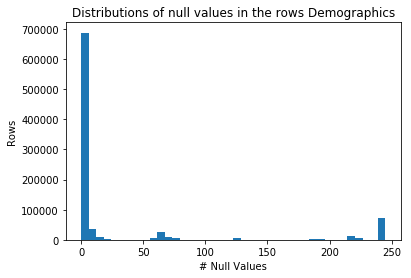

In [25]:
# How much data is missing in each row of the dataset?
plt.hist(azdias.isnull().sum(axis=1), bins=40)
plt.title('Distributions of null values in the rows Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Rows')

We can see that the large majority of the population has less than 50 null fatures. We can remove the datapoints with more than 50 nulls in each row

In [26]:

def drop_rows(df, nulls=50):
    """
    
    """
    df = df.dropna(thresh=df.shape[1]-nulls)
    df = df.reset_index()
    del df['index']
    return df

azdias = drop_rows(azdias)

Text(0,0.5,'Rows')

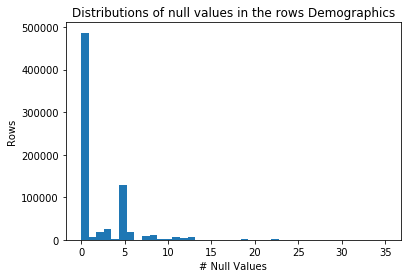

In [27]:
# Now we can check again....
plt.hist(azdias.isnull().sum(axis=1), bins=40)
plt.title('Distributions of null values in the rows Demographics')
plt.xlabel('# Null Values')
plt.ylabel('Rows')

In [28]:
# Let's see how many rows, columns we are left with
azdias.shape

(737288, 286)

### Features Re-encoding
Some categorical features need re-encoding. We will look at the spreadsheet to choose which ones to re-encode.
Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling will be necessary for the remaining two variable types: categorical, and 'mixed'.

Are there binary categorical features that need re-encoding?
Are there multi-level categorical features that need re-encoding?


In [29]:
# Binary categorical features
# OST_WEST_KZ: flag indicating the former GDR/FRG
#azdias['OST_WEST_KZ'].value_counts()
def fix_binary_features(df):
    """
    """
    ost_west_dict = {'OST_WEST_KZ': {'W':0, 'O':1}}
    df = df.replace(ost_west_dict)
    return(df)

azdias = fix_binary_features(azdias)

### One-hot encoding : one-hot encoding doesn't work well with Tree-based methods we intend to use later on,  liked Random Forest or Gradient Boost, so we will not apply it.

In [30]:
# Multi value features
categorical_features = np.intersect1d(azdias_info[azdias_info.Type=='Categorical'].Attribute.values, azdias.columns.values)
azdias_info[azdias_info.Attribute.isin(categorical_features)]

,Attribute,Description,Meaning,Value,Type,Notes
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,unknown,-1,Categorical,NaN
131,CJT_GESAMTTYP,customer journey typology,unknown,0,Categorical,NaN
654,FINANZTYP,best descirbing financial type for the person,unknown,-1,Categorical,NaN
2202,SHOPPER_TYP,shopping typology,unknown,-1,Categorical,NaN
2251,ZABEOTYP,typification of energy consumers,unknown,"-1, 9",Categorical,NaN
712,GFK_URLAUBERTYP,vacation habits,NaN,NaN,Categorical,NaN
1892,LP_FAMILIE_FEIN,familytyp fine,NaN,NaN,Categorical,NaN
65,GEMEINDETYP,NaN,NaN,NaN,Categorical,NaN
93,VK_DHT4A,NaN,NaN,NaN,Categorical,NaN


In [31]:
# OBSOLETE: Actually one-hot encoding doesn't work well with Tree-based methods liked Random Forest or Gradient Boost, 
# so we remove it for now
# We drop LP_FAMILIE_GROB and one-hot encode the other categorical feats

one_hot_encode_cols = np.intersect1d(azdias_info[azdias_info.Type=='Categorical'].Attribute.values, azdias.columns.values)

print(one_hot_encode_cols)

['CAMEO_DEUG_2015' 'CJT_GESAMTTYP' 'FINANZTYP' 'GEMEINDETYP'
 'GFK_URLAUBERTYP' 'LP_FAMILIE_FEIN' 'SHOPPER_TYP' 'VK_DHT4A' 'ZABEOTYP']


In [43]:
def encode_categorical(df, azdias_info):
    """
    """
    
    one_hot_encode_cols = ['CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEMEINDETYP',
         'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'SHOPPER_TYP','VK_DHT4A','ZABEOTYP']
    
    df = df.drop('LP_FAMILIE_GROB', axis=1)
    #df = pd.get_dummies(df, columns=one_hot_encode_cols)
    
    return df

#azdias = encode_categorical(azdias, azdias_info)

### Engineer Mixed-Type Features
There are two of features that we marked as "mixed" in the azdias_info dataframe that require special treatment in order to be included in the analysis. 
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- WOHNLAGE (Residential Area): combines neighboorhood quality and rural/non-rural information. We create two new features NEIGHBORHOOD_QUALITY (Ordinal, vaulues from 1 to 5) and RURAL (Binary, 0= non-rural, 1=rural)
- LP_LEBENSPHASE_FEIN has information over 3 dimensions: Income (from low-income to top-income), Age (younger/middle/older/advanced/retirement) and Family Status (single/couples/families/multiperson households). However his contents are summarized in the LP_LEBENSPHASE_GROB feature that is much easier to interpret, with values from 1 (single low-income) to 12 (high-income earners of higher age from multiperson households). So we keep this last one and we will drop LP_LEBENSPHASE_FEIN


In [32]:
azdias_info[azdias_info.Type == 'Mix-Type']

,Attribute,Description,Meaning,Value,Type,Notes
2054,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,unknown,"-1, 0",Mix-Type,NaN
2229,WOHNLAGE,residential-area,unknown,-1,Mix-Type,NaN
1914,LP_LEBENSPHASE_FEIN,lifestage fine,NaN,NaN,Mix-Type,NaN
1954,LP_LEBENSPHASE_GROB,lifestage rough,NaN,NaN,Mix-Type,NaN
9,CAMEO_INTL_2015,NaN,NaN,NaN,Mix-Type,NaN


In [33]:
azdias.LP_LEBENSPHASE_FEIN.isnull().sum(), azdias.LP_LEBENSPHASE_GROB.isnull().sum()
azdias.LP_LEBENSPHASE_GROB.value_counts()

2.0     139221
1.0     123673
3.0      97455
12.0     65549
4.0      48782
9.0      43717
5.0      42397
10.0     36790
11.0     28511
6.0      24928
8.0      23066
7.0      19773
Name: LP_LEBENSPHASE_GROB, dtype: int64

In [34]:
rural_dict = {1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0, 7.0:1, 8.0:1}
#azdias.WOHNLAGE.value_counts()
azdias['NEIGHBORHOOD_QUALITY'] = np.nan
azdias['NEIGHBORHOOD_QUALITY']  = azdias[(azdias['WOHNLAGE'] > 0) & (azdias['WOHNLAGE'] < 7)]['WOHNLAGE']
azdias['NEIGHBORHOOD_QUALITY'].value_counts()
azdias['RURAL'] = np.nan
azdias['RURAL'] = azdias['WOHNLAGE'].map(rural_dict)
azdias.RURAL.value_counts()

0.0    566716
1.0    170555
Name: RURAL, dtype: int64

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()


14.0    168621
8.0     130753
5.0      80979
10.0     78632
3.0      51159
15.0     38731
11.0     32385
9.0      32180
6.0      25168
12.0     22471
4.0      20103
1.0      18635
2.0       7376
13.0      5063
7.0       3845
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

WOHNLAGE
Residential Area
- -1	unknown
-	0	no score calculated
-	1	very good neighbourhood
-	2	good neighbourhood
-	3	average neighbourhood
-	4	poor neighbourhood
-	5	very poor neighbourhood
-	7	rural neighbourhood
-	8	new building in rural neighbourhood






PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [36]:
# Re-engineer variables
def engineer_variables(df):
    """
    """
    # MAINSTREAM AND GENERATION
    mainstream_dict = {1.0:1, 2.0:2, 3.0:1, 4.0:2, 5.0:1, 6.0:2, 7.0:2, 8.0:1, 9.0:2, 10.0:1, 11.0:2, 12.0:1, 13.0:2, 14.0:1, 15.0:2}
    df['MAINSTREAM'] = np.nan
    df['MAINSTREAM'] = df['PRAEGENDE_JUGENDJAHRE'].map(mainstream_dict)
    generation_dict = {1.0:1, 2.0:1, 3.0:2, 4.0:2, 5.0:3, 6.0:3, 7.0:3, 8.0:4, 9.0:4, 10.0:5, 11.0:5, 12.0:5, 13.0:5, 14.0:6, 15.0:6}
    df['GENERATION'] = np.nan
    df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].map(generation_dict)  
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan) 
    
    rural_dict = {1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0, 7.0:1, 8.0:1}
    df['NEIGHBORHOOD_QUALITY'] = np.nan
    df['NEIGHBORHOOD_QUALITY']  = df[(df['WOHNLAGE'] > 0) & (df['WOHNLAGE'] < 7)]['WOHNLAGE']
    df['NEIGHBORHOOD_QUALITY'].value_counts()
    df['RURAL'] = np.nan
    df['RURAL'] = df['WOHNLAGE'].map(rural_dict)

    # Remove old variables
    df = df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'LP_LEBENSPHASE_FEIN'],axis=1)
    return df

azdias = engineer_variables(azdias)   

We have decided not to one-hot encode categorical variables as it does not help when using Tree-based methods like Decisopn Trees, RandomForest or GradientBoost

In [37]:
# Now we will put all the cleaning into one function, so that we can apply it to the customer database later on
def clean_data(df, azdias_info, cross_validation=False):
    """
    """
    print("Converting unknown to nulls...")
    df = fix_cameo(df)
    df = fix_undocumented_nulls(df)
    df = unknown2nulls(df, azdias_info)
    print("Dropping columns...")
    df = drop_columns(df)
    df = drop_other_columns(df)
    df = drop_categorical(df)
    if cross_validation == False:
        print("Dropping rows...")
        df = drop_rows(df)
    df = fix_binary_features(df)
    # We don't one-hot encode as it doesn't help with Tree based methods we intend to use later on
    #print("One hot encoding...")
    #df = encode_categorical(df, azdias_info)
    print("Engineering new variables...")
    df = engineer_variables(df)
    print("Done.")

    return df

#azdias = clean_data(azdias, azdias_info)

In [38]:
azdias.to_feather('azdias_cleaned.feather')

In [39]:
azdias.shape

(737288, 288)

## Feature Transformation

### Transform Pipeline

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.  In this substep, we will  check the following:

- Before applying the scaler to the data, we need to make sure that we've cleaned the DataFrame of the remaining missing values. This could be as simple as just removing all data points with missing data, thereby losing a significative percentage of the data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. 
- We will separate categorical variables from ordinal and numeric ones, as we will use two different strategies for imputing. Then we intersect with the columns that have null values and finally we add the new engineered Mixed-Type Features
- When imputing, the biggest concern is introducing bias into the data, therefore it's advisable to use different strategies depending on the type of the data. We will use most frequent values for binary variable, median for ordinal ones, and categorical variables have been already handled by creating dummy columns. Finally for numeric columns, if they are skewed we will apply a logarithmic tranform, then impute the median.
- Finally we will use sklearn ColumnTransformer: this estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.



In [430]:
azdias = pd.read_feather('azdias_cleaned.feather', nthreads=2)

/Users/maurizio/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


We have a problem with the D19_ that have a very high number of null values. 
Imputing with a median would introduce an unacceptable bias as the second most frequent value is usually in the few thousands.
Therefor we will:
- impute a zero in the D19_.._QUOTE12 variables (equivalent to "no Online-transactions within the last 12 months")

In [42]:
d19_cols = [col for col in azdias if col.startswith('D19')]
for d19 in d19_cols:
    print("Column {} has {} nulls".format(d19, azdias[d19].isnull().sum()))

d19_features = ['D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12']


Column D19_BANKEN_ONLINE_QUOTE_12 has 164072 nulls
Column D19_GESAMT_ONLINE_QUOTE_12 has 164072 nulls
Column D19_KONSUMTYP_MAX has 0 nulls
Column D19_TELKO_ONLINE_QUOTE_12 has 164072 nulls
Column D19_VERSAND_ONLINE_QUOTE_12 has 164072 nulls
Column D19_VERSI_ONLINE_QUOTE_12 has 164072 nulls


In [43]:
# we select the columns we are left with in each category

ordinal_features = np.intersect1d(azdias_info[azdias_info.Type == 'Ordinal'].Attribute.values, azdias.columns.values)
ordinal_features = np.setdiff1d(ordinal_features, d19_features)
# This one should be empty because we one-hot-encoded them
categorical_features = np.intersect1d(azdias_info[azdias_info.Type == 'Categorical'].Attribute.values, azdias.columns.values)
numeric_features = np.intersect1d(azdias_info[azdias_info.Type == 'Numeric'].Attribute.values, azdias.columns.values)
binary_features =   np.intersect1d(azdias_info[azdias_info.Type == 'Binary'].Attribute.values, azdias.columns.values)
# Mix-Type
mix_type_features = np.intersect1d(azdias_info[azdias_info.Type == 'Mix-Type'].Attribute.values, azdias.columns.values)

# Add Re-engineerd variables
binary_features = np.append(binary_features, 'MAINSTREAM')
ordinal_features = np.concatenate((ordinal_features, ['GENERATION', 'WEALTH', 'FAMILY',  'NEIGHBORHOOD_QUALITY', 'RURAL']))

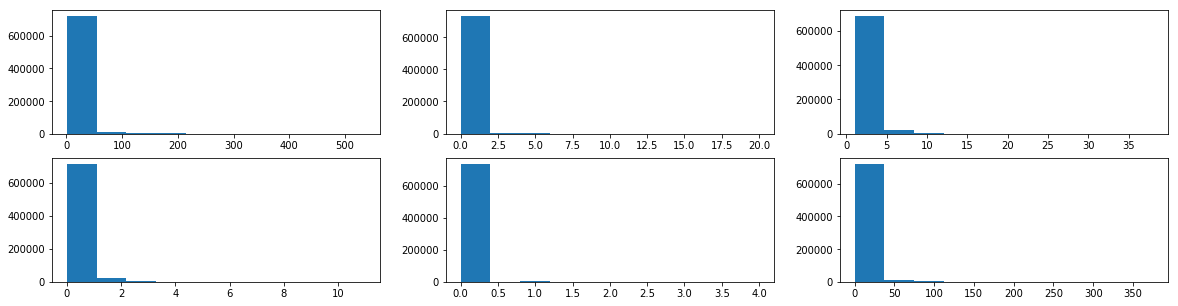

In [40]:
#We now have a look at the distributions of numerical variables
plt.figure(figsize=(20,5))
plt.subplot(2, 3, 1)
plt.hist(azdias.ANZ_HAUSHALTE_AKTIV.dropna());
plt.subplot(2, 3, 2)
plt.hist(azdias.ANZ_HH_TITEL.dropna());
plt.subplot(2, 3, 3)
plt.hist(azdias.ANZ_PERSONEN.dropna());
plt.subplot(2, 3, 4)
plt.hist(azdias.ANZ_KINDER.dropna());
plt.subplot(2, 3, 5)
plt.hist(azdias.ANZ_TITEL.dropna());
plt.subplot(2, 3, 6)
plt.hist(azdias.ANZ_STATISTISCHE_HAUSHALTE.dropna());
plt.show()

The distributions look all right skewed: when data are very non-normal (and e.g. needs a log-transformation to give approximate normality), then any imputation method assuming normality may not perform so well. Therefore we will log-tranform the numerical features before applying imputation

In [47]:
# Check that everything is included
azdias.shape, len(d19_features)+len(numeric_features)+len(ordinal_features)+len(categorical_features)+len(mix_type_features)+len(binary_features)


((737288, 288), 288)

In [48]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

def log_adjusted(x):
    return np.log1p(1+x)

def inv_log_adjusted(x):
    return np.expm1(x)-1
   
# Lof Transform pipeline for numerical features
log_transform = ('log_transform', FunctionTransformer(func = log_adjusted, inverse_func=inv_log_adjusted, validate=False))
log_impute = ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
log_scale = ('log_scale', StandardScaler())

log_pipeline = Pipeline([log_transform, log_impute, log_scale])

binary_pipeline = Pipeline([('binary_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])


categorical_pipeline = Pipeline([('cat_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
                          ('cat_scale', StandardScaler())])

ordinal_impute = ('ordinal_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
ordinal_scale = ('ordinal_scale', StandardScaler())

ordinal_pipeline = Pipeline([ordinal_impute, ordinal_scale])

d19_pipeline = Pipeline([('d19_impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
                          ('d19_scale', StandardScaler())])

mix_pipeline = Pipeline([('mix_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
                          ('mix_scale', StandardScaler())])

# 
# This is elegant but unfortunately does not come with an inverse method, so it will make the calculation 
# of the original values from the PCA much more complicated


transformers = [('log', log_pipeline, numeric_features),
                ('binary', binary_pipeline, binary_features),
                ('cat', categorical_pipeline, categorical_features),
                ('ordinal', ordinal_pipeline, ordinal_features),
                ('mix', mix_pipeline, mix_type_features),
                ('d19', d19_pipeline, d19_features)]

# c_transformer = ColumnTransformer(transformers=transformers)

# So we rather write our own functions to fit_transform, transform and inverse

def fit_features_transform(df):
    """
    
    """
    df[d19_features] = d19_pipeline.fit_transform(df[d19_features])
    df[numeric_features] = log_pipeline.fit_transform(df[numeric_features])
    df[ordinal_features] = ordinal_pipeline.fit_transform(df[ordinal_features])
    df[categorical_features] = categorical_pipeline.fit_transform(df[categorical_features])
    df[mix_type_features] = mix_pipeline.fit_transform(df[mix_type_features])
    df[binary_features] = binary_pipeline.fit_transform(df[binary_features])
    
    return df

def transform_features_transform(df):
    """
    
    """
    df[d19_features] = d19_pipeline.transform(df[d19_features])
    df[numeric_features] = log_pipeline.transform(df[numeric_features])
    df[ordinal_features] = ordinal_pipeline.transform(df[ordinal_features])
    df[categorical_features] = categorical_pipeline.transform(df[categorical_features])
    df[mix_type_features] = mix_pipeline.transform(df[mix_type_features])
    df[binary_features] = binary_pipeline.transform(df[binary_features])
    
    return df


def inv_features_transformation(df):
    """
    
    """
    df[d19_features] = d19_pipeline.named_steps['d19_scale'].inverse_transform(df[d19_features])
    df[numeric_features] = log_pipeline.named_steps['log_scale'].inverse_transform(df[numeric_features])
    df[numeric_features] = log_pipeline.named_steps['log_transform'].inverse_transform(df[numeric_features])
    df[ordinal_features] = ordinal_pipeline.named_steps['ordinal_scale'].inverse_transform(df[ordinal_features])
    df[categorical_features] = categorical_pipeline.named_steps['cat_scale'].inverse_transform(df[categorical_features])
    df[mix_type_features] = mix_pipeline.named_steps['mix_scale'].inverse_transform(df[mix_type_features])
    
    
    return df
    

azdias_transformed = fit_features_transform(azdias)

azdias_transformed.shape, azdias.shape

/Users/maurizio/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log1p


((737288, 288), (737288, 288))

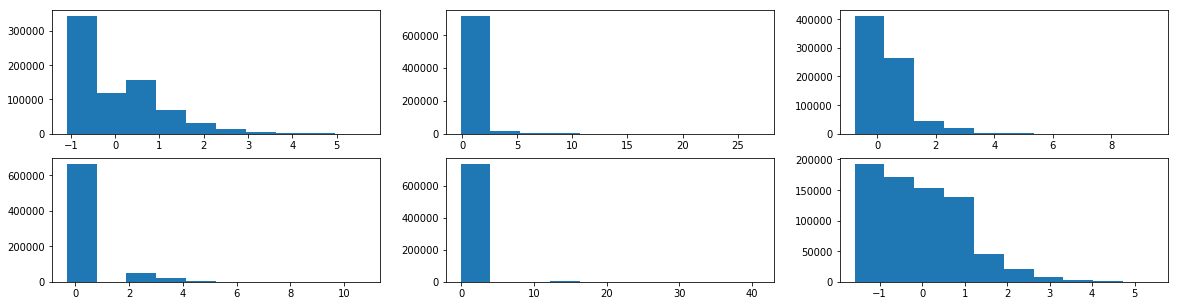

In [137]:
#We now can check again the distributions of numerical variables
plt.figure(figsize=(20,5))
plt.subplot(2, 3, 1)
plt.hist(azdias_transformed.ANZ_HAUSHALTE_AKTIV);
plt.subplot(2, 3, 2)
plt.hist(azdias_transformed.ANZ_HH_TITEL);
plt.subplot(2, 3, 3)
plt.hist(azdias_transformed.ANZ_PERSONEN);
plt.subplot(2, 3, 4)
plt.hist(azdias_transformed.ANZ_KINDER);
plt.subplot(2, 3, 5)
plt.hist(azdias_transformed.ANZ_TITEL);
plt.subplot(2, 3, 6)
plt.hist(azdias_transformed.ANZ_STATISTISCHE_HAUSHALTE);
plt.show()

In [49]:
azdias.to_feather('azdias_transformed.feather')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA
On the scaled data, we are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:

from sklearn.decomposition import PCA

In [63]:
pca = PCA()
pca.fit(azdias_transformed)
azdias_pca = pca.transform(azdias_transformed)

In [55]:
def show_pca(pca):
    cumulative_ratios=np.zeros(len(pca.explained_variance_ratio_))
    for i in range(len(pca.explained_variance_ratio_)):
        cumulative_ratios[i]=np.sum(pca.explained_variance_ratio_[:i])
    plt.figure(figsize=(20,10))
    plt.plot(pca.explained_variance_ratio_)
    plt.plot(cumulative_ratios)
    plt.xlabel("Components")
    plt.ylabel("Explained Variance Ratio %")
    plt.title("PCA Components Explained Variance Ratios")
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xticks(np.arange(0, len(pca.explained_variance_ratio_)+2, step= (len(pca.explained_variance_ratio_) // 20)))
    plt.grid(linewidth=0.1)
    plt.legend(['Variance Ratio', 'Cumulative'], loc='center right')
    
#show_pca(pca)

In [66]:
np.sum(pca.explained_variance_ratio_[:140])

0.9075089815692422

In [67]:
azdias_transformed.shape

(737288, 288)

The pca without parameters returned all the 289 components (same as n. of features)
The plot shows that over 80% of the variance is explained by the first 90 components, 90% by the first 140 components and after that it increases very slowly

So we will run it again but this time we want only 140 components. Also we are saving the pca object so we can ru it 
on the customer dataset later on

In [53]:
def apply_pca(df, n_components=300):
    """
    
    """
    pca = PCA(n_components=n_components)
    pca.fit(df)
    df_pca = pca.transform(df)
    
    return df_pca, pca

azdias_pca, pca = apply_pca(azdias_transformed, 140)

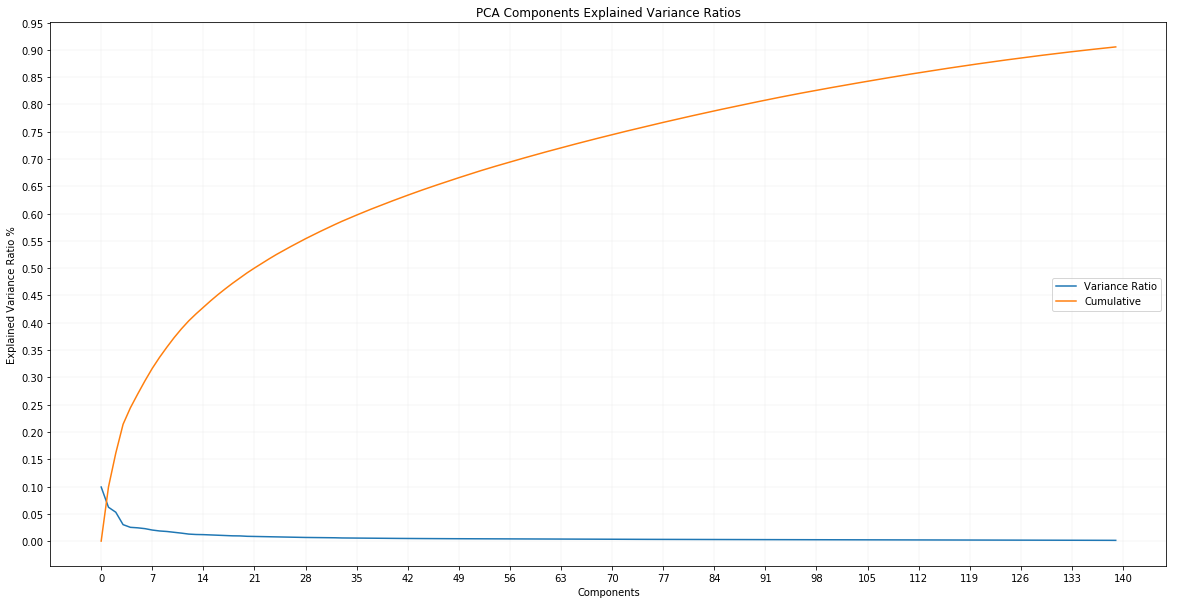

In [56]:
show_pca(pca)

In [314]:
import pickle
azdias.to_feather('azdias_pca.feather')

# Save to file in the current working directory
pkl_filename = "pca.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(pca, file)

In [57]:
def pca_results(full_dataset, pca, component):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (20,10))

    # Plot the feature weights as a function of the components
    features_to_show = components.iloc[component - 1].sort_values(ascending=False)
    features_to_show = features_to_show[np.absolute(features_to_show.values) >= 0.01]
    #components.iloc[component - 1].sort_values(ascending=False).plot(ax = ax, kind = 'bar');
    features_to_show.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(list(features_to_show.keys()), rotation=90)
    ax.set_xlabel("Features")

    # Display the explained variance ratios
    #for i, ev in enumerate(pca.explained_variance_ratio_):
    ev = pca.explained_variance_ratio_[component-1]
    
    plt.title("Component {} Explained Variance: {:.2f}%".format(component, ev*100))

    # Return a concatenated DataFrame
    #return pd.concat([variance_ratios, components], axis = 1).iloc[component - 1].sort_values(ascending=False)
    return features_to_show

### First Component

PLZ8_ANTG3                    0.1478
KBA13_ANTG3                   0.1470
KBA13_ANTG4                   0.1442
KBA13_BAUMAX                  0.1430
PLZ8_ANTG4                    0.1427
PLZ8_BAUMAX                   0.1412
ANZ_HAUSHALTE_AKTIV           0.1406
ANZ_STATISTISCHE_HAUSHALTE    0.1385
CAMEO_DEUG_2015               0.1375
WEALTH                        0.1352
HH_EINKOMMEN_SCORE            0.1303
EWDICHTE                      0.1213
ORTSGR_KLS9                   0.1213
FINANZ_HAUSBAUER              0.1028
PLZ8_ANTG2                    0.0985
ARBEIT                        0.0978
KBA13_HALTER_30               0.0955
KBA05_ANTG4                   0.0939
KBA13_HALTER_35               0.0908
KBA05_ANTG3                   0.0881
STRUKTURTYP                   0.0852
RELAT_AB                      0.0841
KBA05_BAUMAX                  0.0837
ZABEOTYP                      0.0831
CJT_TYP_2                     0.0782
KBA13_ANTG2                   0.0757
KBA13_ALTERHALTER_30          0.0700
F

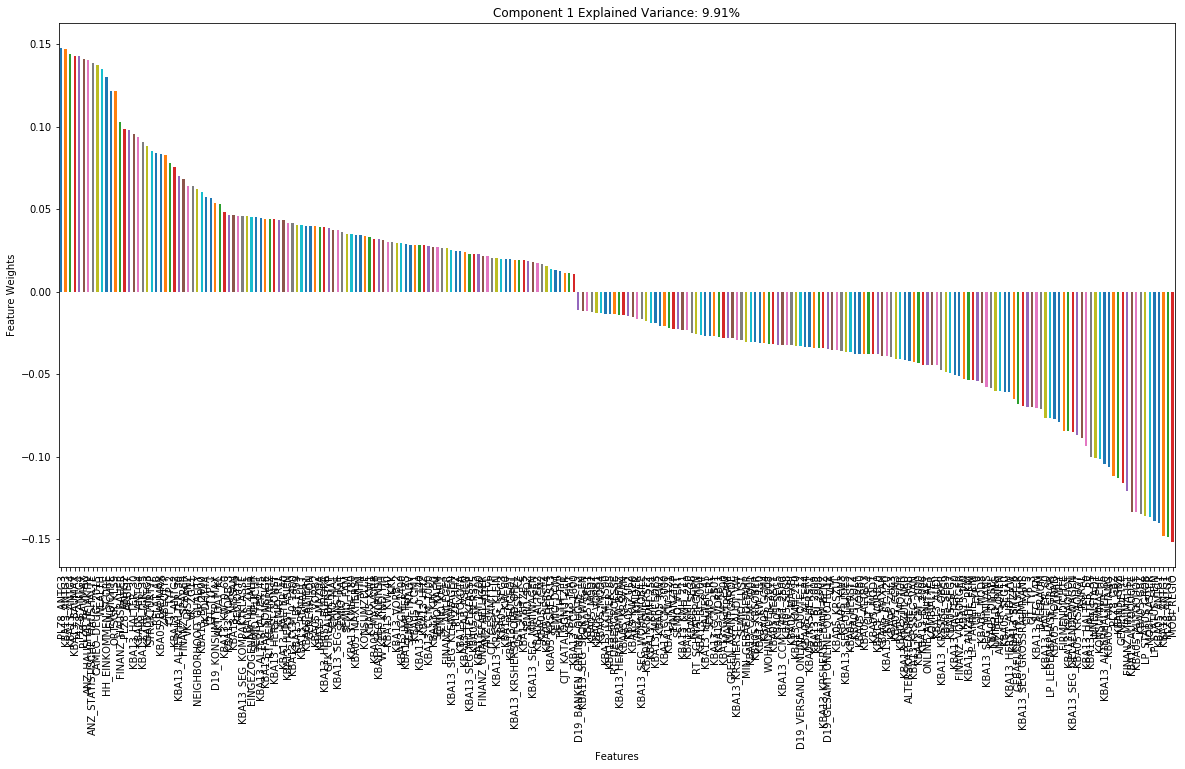

In [61]:
pca_results(azdias_transformed, pca, 1)

Positive correlations
- PLZ8_ANTG3: # of 6-10 family houses in the area
- PLZ8_ANTG4 # of +10 families in the area  
- KBA13_BAUMAX : Building type
- ANZ_HAUSHALTE_AKTIV # of households in the building
- WEALTH: here small value means wealthy households, high values poorer households
- KBA13_ANTG3 and KBA13_ANTG4 unfortunately are undocumented

Neg Correlations:
- MOBI_REGIO: mobility patterns, where a higher value means low mobility, more stability
- PLZ_ANTG1: share of small families
- LP_STATUS_FEIN/GROB: Social status

So this component is positively correlated to share of bigger families (more densily populated, less wealthy) in the area and building and negatively correlated with social status and stability (younger, not wealthy tend to rent and change often) 

In [82]:
# We set apart the most important positively and negatively correlated fetures
first_component_pos = ['PLZ8_ANTG3','KBA13_ANTG3','KBA13_ANTG4','KBA13_BAUMAX','PLZ8_ANTG4','PLZ8_BAUMAX','ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','CAMEO_DEUG_2015','WEALTH']
first_component_neg = ['LP_STATUS_GROB','MOBI_RASTER','LP_STATUS_FEIN','KBA05_ANTG1','KBA13_ANTG1','PLZ8_ANTG1','MOBI_REGIO']


### Second Component

KBA13_HERST_BMW_BENZ           0.1876
KBA13_SEG_OBEREMITTELKLASSE    0.1603
KBA13_MERCEDES                 0.1601
KBA13_BMW                      0.1566
KBA13_SITZE_4                  0.1468
KBA13_SEG_SPORTWAGEN           0.1440
KBA13_KMH_211                  0.1324
KBA05_HERST1                   0.1320
KBA13_KMH_250                  0.1301
KBA13_KW_121                   0.1287
KBA13_SEG_OBERKLASSE           0.1261
KBA13_CCM_2501                 0.1222
KBA05_KW3                      0.1219
KBA13_CCM_3000                 0.1138
KBA13_KRSHERST_BMW_BENZ        0.1137
KBA05_MOTOR                    0.1134
KBA13_CCM_3001                 0.1085
KBA05_MOD1                     0.1079
KBA05_CCM4                     0.1073
EWDICHTE                       0.1033
KBA13_HALTER_65                0.1003
KBA05_SEG5                     0.0981
STRUKTURTYP                    0.0956
ORTSGR_KLS9                    0.0919
KBA13_CCM_2500                 0.0907
KBA05_CCM3                     0.0848
KBA05_SEG8  

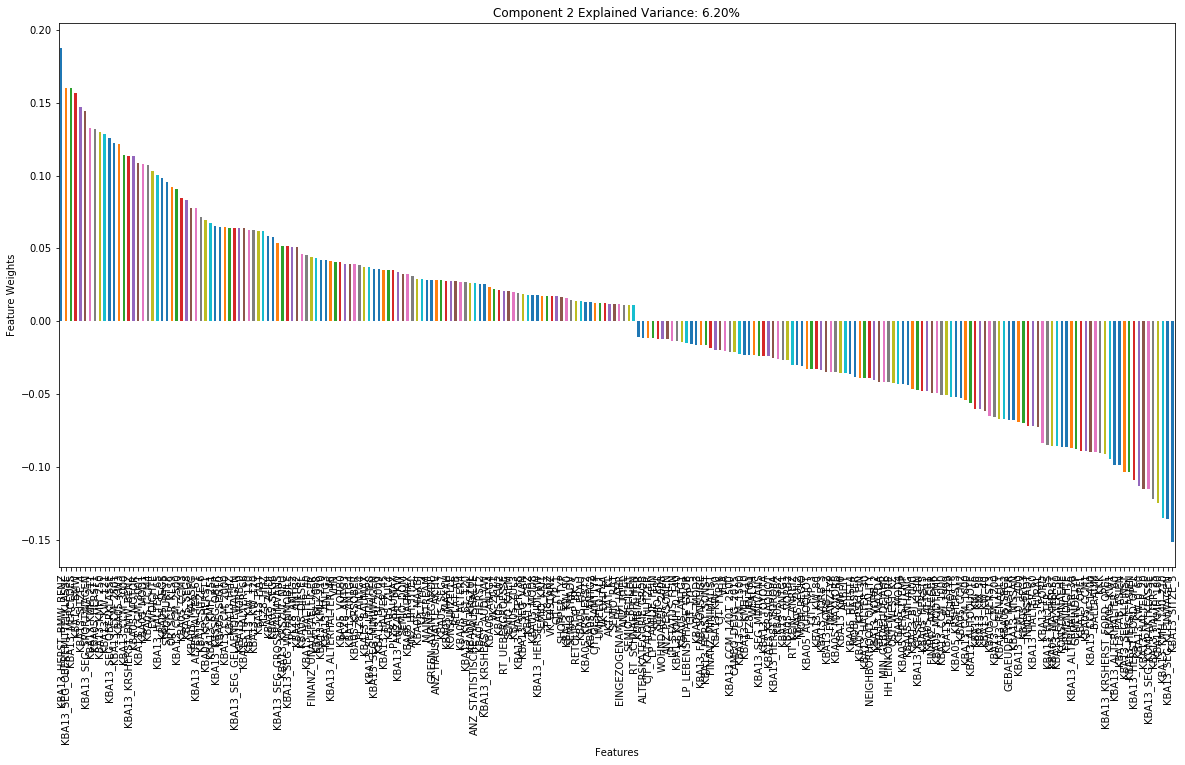

In [62]:
# Second component
pca_results(azdias_transformed, pca, 2)

Positive Corr:
KBA13_HERST_BMW_BENZ           0.1890: Share of BMW & Mercedes in the area
KBA13_SEG_OBEREMITTELKLASSE    0.1621: share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
KBA13_MERCEDES                 0.1608: share of Mercedes in the area
KBA13_BMW : share of BMW in the area
KBA13_SEG_SPORTWAGEN: Share of sportcars
    
Negatice corr:
KBA13_SEG_KLEINWAGEN:    Share of small cars
KBA13_KMH_140_210 : Share of cars with max speed between 140 and 210
KBA13_HALTER_25, KBA13_HALTER_20: Young drivers

Looks like this component is positively correlated with uppr-middle class indicators like owning a BMW, Merc or Sportcar, mature drivers



### Third Component

KOMBIALTER                     0.2206
FINANZ_VORSORGER               0.1968
CJT_TYP_5                      0.1923
ALTERSKATEGORIE_GROB           0.1899
CJT_TYP_4                      0.1826
CJT_TYP_3                      0.1783
CJT_TYP_6                      0.1764
SEMIO_LUST                     0.1428
CJT_KATALOGNUTZER              0.1401
RETOURTYP_BK_S                 0.1371
SEMIO_ERL                      0.1279
FINANZ_MINIMALIST              0.1111
W_KEIT_KIND_HH                 0.1062
FINANZTYP                      0.1024
WOHNDAUER_2008                 0.0621
VK_DHT4A                       0.0559
FINANZ_HAUSBAUER               0.0544
KBA05_ALTER4                   0.0539
SHOPPER_TYP                    0.0519
KBA13_ANTG3                    0.0476
KBA05_MAXAH                    0.0473
ARBEIT                         0.0463
PLZ8_ANTG3                     0.0460
EWDICHTE                       0.0457
KBA05_VORB0                    0.0453
KBA13_ANTG4                    0.0442
ORTSGR_KLS9 

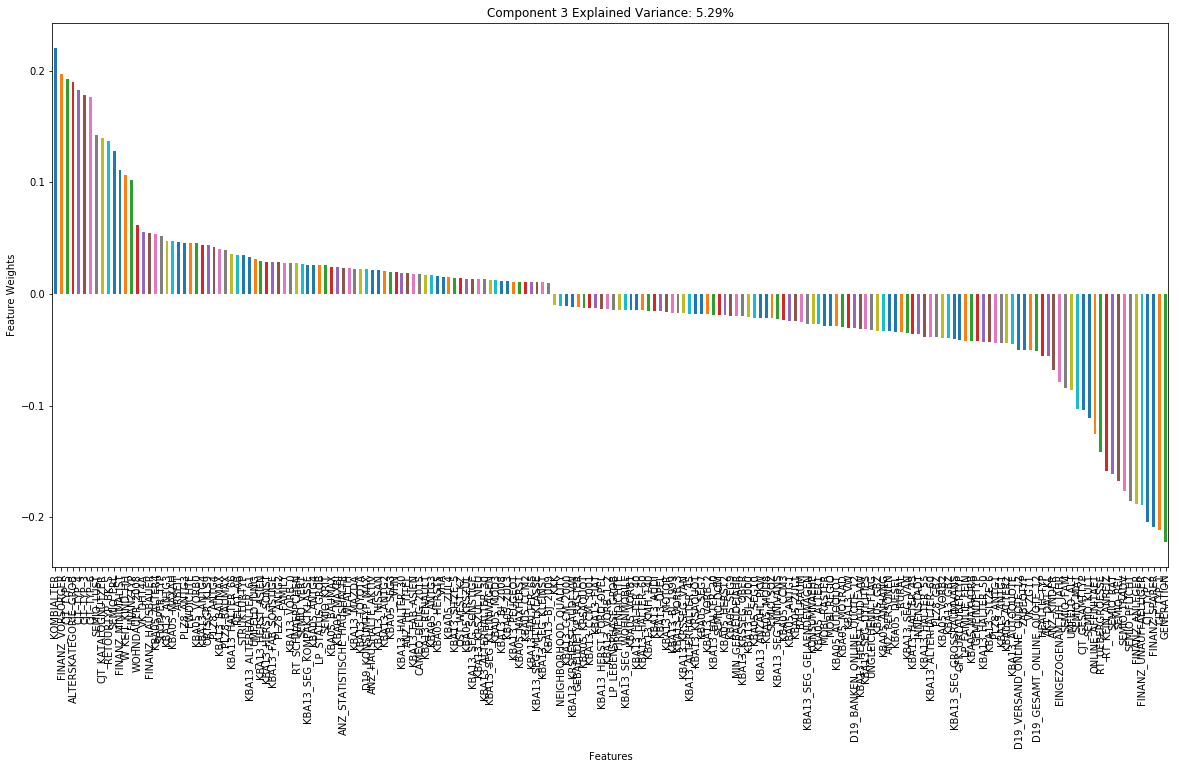

In [64]:
pca_results(azdias_transformed, pca, 3)

Positively Corr:
KOMBIALTER                     0.2217
FINANZ_VORSORGER               0.1992: Financially: be preparer
CJT_TYP_5                      0.1927  Customer-Journey-Typology relating to the preferred information and buying channels of consumers
                                       Advertising- and Cross-Channel-Enthusiast
ALTERSKATEGORIE_GROB           0.1909 Age classification: higher -> older
CJT_TYP_4                      0.1834 advertisinginterested Online-shopper
CJT_TYP_3                      0.1782  advertisinginterested Store-shopper
CJT_TYP_6 Advertising-Enthusiast with restricted Cross-Channel-Behaviour 

Neg Corr
SEMIO_PFLICHT                 -0.1870 Traditionally minded (higher == less affinity)
FINANZ_UNAUFFAELLIGER         -0.1888 Financial Typology: unremarkable (higher = low)
FINANZ_ANLEGER                -0.1915 Investor? (high value = low likelihood)
CJT_TYP_2                     -0.2043 Advertising- and Consumptiontraditionalist
FINANZ_SPARER                 -0.2101 money saver (low value = very high)
CJT_TYP_1                     -0.2119 Advertising- and Consumptionminimalist
GENERATION (higher values == younger)

So this component is indicating the Customer Journey, Financial Attitude and Age. Higher component indicates higher probability of people being of higher age and money savers. The CJT_TYP_X variables indicate max affinity with the typology when value=1, lowest affinity when value=5


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In this step, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, we compute the average difference from each point to its assigned cluster's center.
- We perform the above two steps for a number of different cluster counts.
- We use the elbow method to select a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. We obtain the cluster assignments for the general demographics data.

I am using these functions instead of model.score to calculate the average distance of the points in the cluster 
from the centroid. I play with it first in two dimensions and then generalize to n-dimensions

Thanks to alphaleonis and Shay.G at https://stackoverflow.com/questions/40828929/sklearn-mean-distance-from-centroid-of-each-cluster for some of the code

### Distance in two dimensions
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)


### Distance in n-dimensions
def k_mean_distance_n(data, centroid, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.linalg.norm(x - centroid) for x in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)

In [68]:
from sklearn.cluster import MiniBatchKMeans, KMeans

# Distance in two dimensions
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)


# Distance in n-dimensions
def k_mean_distance_n(data, centroid, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.linalg.norm(x - centroid) for x in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.mean(distances)

In [80]:
# We set the max num of clusters to 30: this will take a while
max_clusters = 30
    
# compute the average within-cluster distances.
def k_means_score(data, n_clusters):
    # Run k-means
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=20000)
    #kmeans = KMeans(n_clusters=n_clusters)
    model = kmeans.fit(data)
    labels = model.predict(data)
    centroids = model.cluster_centers_
    
    total_distance = []
    for i, c in enumerate(centroids):
        # Function from above
        mean_distance = k_mean_distance_n(data, c, i, labels)
        total_distance.append(mean_distance)
    return(np.mean(total_distance))
  
scores = []
clusters = list(range(1,max_clusters+1))

import progressbar
cnter = 0
bar = progressbar.ProgressBar(maxval=len(clusters)+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

for n_clusters in clusters:
    scores.append(k_means_score(azdias_pca, n_clusters))
    cnter+=1 
    bar.update(cnter)


bar.finish()    
print(scores)

[========================================================================] 100%


[15.812893466777476, 15.191622317292907, 15.053744988609475, 14.918968708345956, 14.644092642908607, 14.575319309086618, 14.51076687784695, 14.397664203218511, 14.306981005813546, 14.32727011870374, 14.238092946590099, 14.291563000878183, 14.191321998776662, 14.135948304128997, 14.138844120433864, 14.03282762014145, 14.040373623663543, 14.024380090208572, 13.997734041516532, 13.983414542892627, 13.963053947728516, 13.984064943744558, 13.91246077011756, 13.93388360496158, 13.897611648137756, 13.86910655638807, 13.878245880062154, 13.840493542142136, 13.794696663073838, 13.817897632601179]


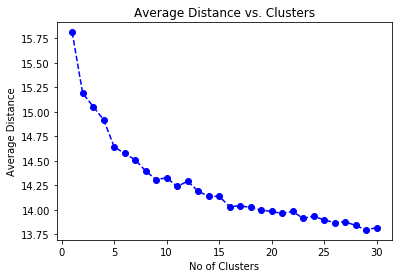

In [81]:
# We will use the elbow method to find the ideal number of clusters
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('No of Clusters');
plt.ylabel('Average Distance');
plt.title('Average Distance vs. Clusters');


Running MiniBatchKMeans instead of KMeans makes the graph a bit bumpier as the average distance does not always decreases with n. of clusters. However, the general trend is the same. 
The graph above shows an elbow at 16 clusters and after 25 the average distance  keeps on decreasing at much lower pace.

In [69]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
def apply_KMeans(df_pca, n_clusters):
    """
    
    """
    
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=50000, random_state=3425)
    kmeans_model = kmeans.fit(df_pca)
    pop_labels = kmeans_model.predict(df_pca)
    pop_centroids = kmeans_model.cluster_centers_
    
    return pop_labels, pop_centroids, kmeans_model

gen_labels, gen_centroids, k_model = apply_KMeans(azdias_pca, 16)

In [71]:
# Save to file in the current working directory
#pkl_filename = "kmeans.pkl"  
#with open(pkl_filename, 'wb') as file:  
#    pickle.dump(k_model, file)

### Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, we can see how the customer data maps on to those clusters. We will use the fits from the general population to clean, transform, and cluster the customer data. Finally we  will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [72]:
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/maurizio/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
# Cleaning Data
#'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP columns will be dropped
customers = customers.drop(labels=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)
customers = clean_data(customers, azdias_info)

[                                                                        ] N/A%

Converting unknown to nulls...


[========================================================================] 100%


Dropping columns...
Dropped 71 columns.
Dropping rows...
Engineering new variables...
Done.


In [414]:
customers.shape
#pd.get_dummies(customers, columns=one_hot_encode_cols)

(134246, 362)

In [74]:
customers_transformed = transform_features_transform(customers)
cust_pca = pca.transform(customers)

customer_labels = k_model.predict(cust_pca)
customer_centroids = k_model.cluster_centers_

/Users/maurizio/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log1p


### Step 3.3: Compare Customer Data to Demographics Data

In [75]:
np.bincount(gen_labels)/len(gen_labels)

array([0.07322783, 0.08090054, 0.03748603, 0.05286401, 0.06771845,
       0.07041617, 0.07744463, 0.06334838, 0.0610684 , 0.07248185,
       0.07771454, 0.05187796, 0.0487747 , 0.07244659, 0.04518723,
       0.04704268])

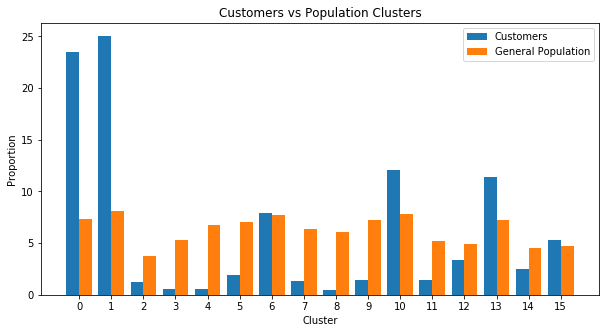

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
n_clusters=16
plt.figure(figsize=(10,5))
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

population_bins = 100 * np.bincount(gen_labels)/len(gen_labels)
customer_bins = 100 * np.bincount(customer_labels)/len(customer_labels)
clusters = [x for x in range(0,n_clusters)]
ax = plt.subplot(111)
w=0.4
ax.bar(x=np.array(clusters)-0.2, height=customer_bins, width=w, color=tableau20[0])
ax.bar(x=np.array(clusters)+0.2, height=population_bins, width=w, color=tableau20[2])
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.xticks(clusters)
plt.legend(['Customers', 'General Population'])
plt.title('Customers vs Population Clusters')
plt.show()



We can see here that clusters 0, 1 are significantly more represented in the customer dataset compared to the general population, while clusters  3, 4, 7, 8 are under-represented.

From the previous analysis of the PCA we have:
- First Component:So this component is positively correlated to share of bigger families (more densily populated, less wealthy) in the area and building and negatively correlated with social status and stability (younger, not wealthy tend to rent and change often)

- Second Component: This component is positively correlated with uppr-middle class indicators like owning a BMW, Merc or Sportcar, mature drivers. We will look at the variables: KBA13_HERST_BMW_BENZ, KBA13_SEG_OBEREMITTELKLASSE, KBA13_MERCEDES, KBA13_BMW, KBA13_SEG_SPORTWAGEN (sport ans luxury cars). And the negatively correlated KBA13_SEG_KLEINWAGEN, KBA13_KMH_140_210 (cheap cars) and KBA13_HALTER_25, KBA13_HALTER_20 (Young drivers)

- Third Component: This component is indicating the Customer Journey, positively correlated with younger and more 
multi-channel enthusiast people and negatively correlated with traditionalist, older people. We will look at the variables KOMBIALTER, FINANZ_VORSORGER, CJT_TYP_5, ALTERSKATEGORIE_GROB, CJT_TYP_4, CJT_TYP_3, CJT_TYP_6. 
Neg Correlated ones: SEMIO_PFLICHT, FINANZ_UNAUFFAELLIGER, FINANZ_ANLEGER, CJT_TYP_2, FINANZ_SPARER, CJT_TYP_1 and 
GENERATION (higher values == younger)

We will use the .inverse_transform() method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.


In [77]:
# We calculate the inverse tranformation to retrieve the original values associated to the centroids
centroids_df = pd.DataFrame(pca.inverse_transform(customer_centroids), columns=customers.columns)
centroids_df = inv_features_transformation(centroids_df)

over_represented = [0, 1]
under_represented = [3, 4, 7, 8]


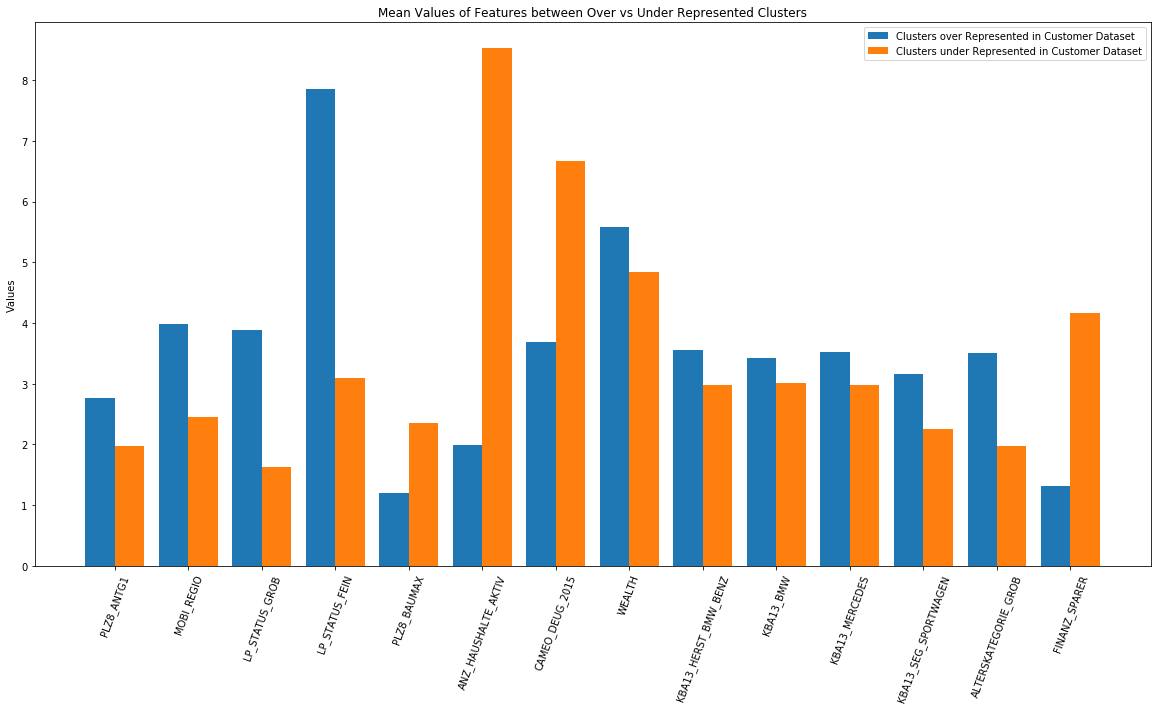

In [136]:
# Visualizations
#pos1 = list(first_component_pos)+list(second_component_pos)+list(third_component_pos)+list(first_component_neg)+list(second_component_neg)+list(third_component_neg)

clust_features = ['PLZ8_ANTG1','MOBI_REGIO', 'LP_STATUS_GROB', 'LP_STATUS_FEIN','PLZ8_BAUMAX', 'ANZ_HAUSHALTE_AKTIV', 'CAMEO_DEUG_2015', 'WEALTH',
     'KBA13_HERST_BMW_BENZ', 'KBA13_BMW', 'KBA13_MERCEDES', 'KBA13_SEG_SPORTWAGEN', 'ALTERSKATEGORIE_GROB', 'FINANZ_SPARER']

over_rep = centroids_df.loc[over_represented, clust_features].mean()
under_rep = centroids_df.loc[under_represented, clust_features].mean()
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
features_idxs = [x for x in range(0,len(clust_features))]
ax.bar(x=np.array(features_idxs)-0.2, height=over_rep.values, width=w, color=tableau20[0])
ax.bar(x=np.array(features_idxs)+0.2, height=under_rep.values, width=w, color=tableau20[2])
plt.ylabel('Values')

plt.xticks(np.array(features_idxs), over_rep.index, rotation=70)
plt.legend(['Clusters over Represented in Customer Dataset', 'Clusters under Represented in Customer Dataset'])
plt.title('Mean Values of Features between Over vs Under Represented Clusters')
plt.show()
#+third_component_neg

From the graph above we can see that in the clusters that are over represented in the Customers dataset we find data points with higher values of measures of wealth like LP_STATUS_FEIN, LP_STATUS_GROB, CAMEO_DEUG_2015 (this last one is in inverted scale from wealthier to poorer). They tend to be less mobile that the general population (MOBI_REGIO, also in inverted scale), they live in buildings with a smaller number of housholds. They tend to drive luxury cars, they do not belong to younger generation (ALTERSKATEGORIE_GROB) and they have a more conservative approach to financial investments (FINANZ_SPARER). 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [169]:
# Let's check how the data is balanced
(mailout_train.RESPONSE == 1).mean()

0.012383036171500396

The data is highly unbalanced as only 1.24% of the people responded to te mailout campaign.
This will affect:
- the metric to use, as obvsiouly accuracy won't give us the information we need. We will use ROC AUC instead
- the cross validation strategy: we will use Stratified KFold, a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [142]:
mailout_train.shape

(42962, 367)

In [170]:
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)

In [171]:
# We won't drop too many rows, so we can preserve data
X = clean_data(X, azdias_info, cross_validation=True)
x_columns=X.columns

X = transform_features_transform(X)

[==                                                                      ]   3%

Converting unknown to nulls...


[========================================================================] 100%


Dropping columns...
Dropped 71 columns.
Engineering new variables...
Done.


In [3]:
# Save/Load in case the kernel dies
#pd.DataFrame(X, columns=x_columns).to_feather('X_mailout_train.feather')
#X = pd.read_csv('X_mailout_train.csv', nthreads=2)

/Users/maurizio/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [207]:
X.to_csv('X_mailout_train.csv')

Now we will compare some supervised leaning algorithms. Tree Based approached usually work well with tabular data and are preferred in most Kaggle competitions, particularly "boosting" ones whcih tend to give higher accuracy.

In [148]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


# TODO: Initialize the three models

clf_A = DecisionTreeClassifier(random_state=42)

clf_B = RandomForestClassifier(random_state=42)

clf_C = AdaBoostClassifier(random_state=42)

clf_D = XGBClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y)
samples_10 = len(y) // 10
samples_1 = len(y) // 100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    samples = samples_100
    #for i, samples in enumerate([samples_1, samples_10, samples_100]):
    #results[clf_name] = train_predict(clf, samples, X_train, y_train, X_CV, y_cv)
    results[clf_name] = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')

# Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    #print(clf_name + " trained in {} seconds".format(results[clf_name]['train_time']))
    #print(clf_name + " Fbeta Training {}".format(results[clf_name]['f_train']))
    #print(clf_name + " Fbeta Test {}\n".format(results[clf_name]['f_test']))
    #print(clf_name + " ROC AUC Training {}\n".format(results[clf_name]['auc_train']))
    print(clf_name + " ROC AUC Test {}\n".format(results[clf_name]))
    

/Users/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/maurizio/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/maurizio/anaconda3/lib/py

DecisionTreeClassifier ROC AUC Test [0.49762831 0.47868562 0.47199438 0.51223714 0.50033073]

RandomForestClassifier ROC AUC Test [0.52603794 0.50836782 0.51465566 0.49712957 0.51837433]

AdaBoostClassifier ROC AUC Test [0.64997489 0.63741104 0.6701515  0.6394789  0.6338392 ]

XGBClassifier ROC AUC Test [0.65530362 0.66488014 0.72207887 0.68383497 0.69148965]



In [150]:
X.shape, y.shape

((42962, 288), (42962,))

In [151]:
# We will compare few methods by reusing the code from the "Finding Donors" project
# Learning Curves, to have a look at Bias/Variance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from plot_learning_curve import plot_learning_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')


roc_scorer = 'roc_auc'
# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=42)
clf_B = RandomForestClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)
clf_D = XGBClassifier(random_state=42)

X = X.values
y = y.values


cv = StratifiedKFold(n_splits=5)


None


We will run the model one at the time because of memory errors I get when trying to run all the 4 of them in the same script

<module 'matplotlib.pyplot' from '/Users/maurizio/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

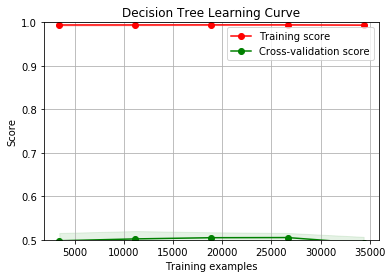

In [152]:
# Decision Trees
plot_learning_curve(clf_A, 'Decision Tree Learning Curve', X, y, scorer=roc_scorer, cv=cv, ylim=(0.5, 1), n_jobs=2)

<module 'matplotlib.pyplot' from '/Users/maurizio/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

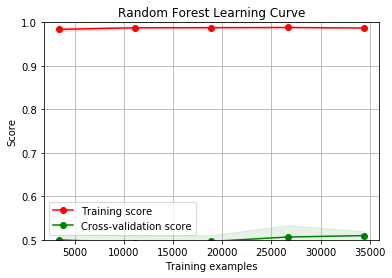

In [153]:
# Random Forests
plot_learning_curve(clf_B, 'Random Forest Learning Curve', X, y, scorer=roc_scorer, cv=cv, ylim=(0.5, 1), n_jobs=2)

<module 'matplotlib.pyplot' from '/Users/maurizio/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

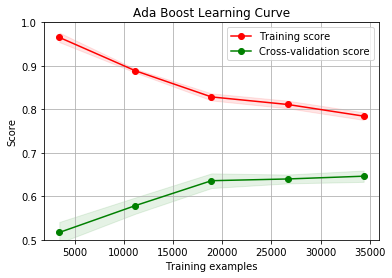

In [154]:
plot_learning_curve(clf_C, 'Ada Boost Learning Curve', X, y, scorer=roc_scorer, cv=cv, ylim=(0.5, 1), n_jobs=2)

<module 'matplotlib.pyplot' from '/Users/maurizio/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

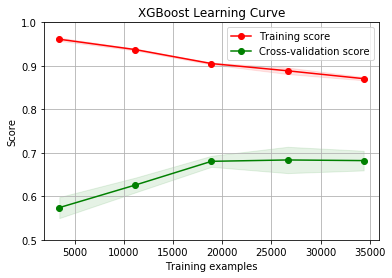

In [155]:
plot_learning_curve(clf_D, 'XGBoost Learning Curve', X, y, scorer=roc_scorer, cv=cv, ylim=(0.5, 1), n_jobs=2)


<module 'matplotlib.pyplot' from '/Users/maurizio/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

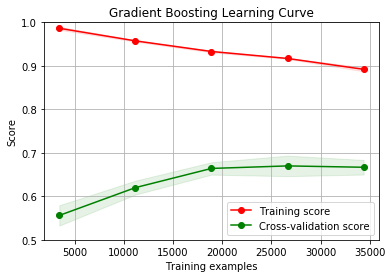

In [62]:
clf = GradientBoostingClassifier(random_state=42)
plot_learning_curve(clf, 'Gradient Boosting Learning Curve', X, y, scorer=roc_scorer, cv=cv, ylim=(0.5, 1), n_jobs=2)

The learning curves above show that Decision trees and Random Forest overfit the the training data when used without tuning any parameter and the performance on the CV data is quite poor. Boosting methods do much better, especially XGBoost and Gradient Boosting show that there is room for improvement by tuning the parameters. However both these algorithms are quite slow (at least on my Macbook) and each iteration on the full dataset using StratifiedKFold with 5 folds takes around 140 secs. Therefore we must be careful not to run a GridSearch with a big grid as it could run forever: for example if we have 5 parameters with 5 possible values each trhen we would require 3125 iterations do complete the GridSearch (52 hours), if we are lucky enouth that the process doesn't crash in the meantime. One alternative approach is to optimize the parameters in sequence, as described [here](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e) and [here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [160]:
from time import time
start = time()
res_xgb = cross_val_score(clf_D, X, y, cv=cv, scoring='roc_auc', n_jobs=2)
end = time()
print("XGBoost executed in {} seconds. CV average score: {}".format(end - start, res_xgb.mean()))


XGBoost executed in 146.4204158782959 seconds. CV average score: 0.6835174517319864


In [161]:
start = time()
res_gboost = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=2)
end = time()
print("Gradient Boosting executed in {} seconds. CV average score: {}".format(end - start, res_gboost.mean()))



Gradient Boosting executed in 143.97069430351257 seconds. CV average score: 0.6835174517319864


### Tuning XGBoost
So the approach we will follow to tune the parameters is as follows:
* Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
* Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees.
* Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
* Lower the learning rate and decide the optimal parameters


In [232]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV   #Performing grid search

warnings.filterwarnings('default')

def modelfit(alg, dtrain, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, stratified=True, verbose_eval=10)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, target, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print("\nModel Report")
    #print("Accuracy : %.4g" %accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(target, dtrain_predprob))
    print("CV Result: ", cvresult)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore())[:30].sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances: top 30')
    plt.ylabel('Feature Importance Score')

[0]	train-auc:0.615531+0.0591235	test-auc:0.598163+0.0592772
[50]	train-auc:0.904233+0.00316453	test-auc:0.686786+0.0257959

Model Report
AUC Score (Train): 0.779869


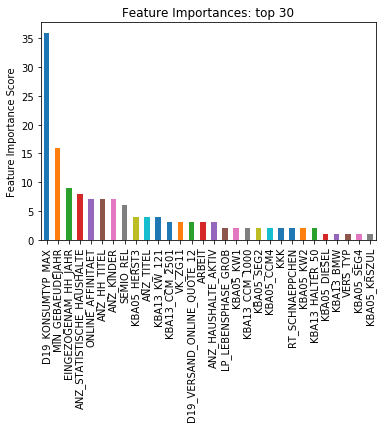

In [227]:
# We start with the following parameters:
# max_depth = 5 : This should be between 3-10.
# min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
# gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
# subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
# scale_pos_weight = 1: Because of high class imbalance.

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=2,
 scale_pos_weight=1,
 random_state=27)


modelfit(xgb1, X, y)

In [205]:
# Tuning size of the trees: max_depth, min_child_weight: takes ~ 2 hours
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', n_jobs=2, scale_pos_weight=1, random_state=27), 
param_grid = param_test1, scoring='roc_auc', n_jobs=2, iid=False, cv=5)

gsearch1.fit(X,y)
gsearch1.best_params_, gsearch1.best_score_

In [206]:
#gsearch1.best_params_, gsearch1.best_score_
gsearch1.error_score

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [209]:
#Since we took steps of 2 now we can look for optimum parameters
param_test2 = {
 'max_depth':[3,4],
 'min_child_weight':[1,2]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
param_grid = param_test2, scoring='roc_auc', n_jobs=2, iid=False, cv=5)

gsearch2.fit(X,y)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.6869285779563363)

In [219]:
# Now we tune Gamma: specifies the minimum loss reduction required to make a split
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=2,iid=False, cv=5)

gsearch3.fit(X,y)

gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.3}, 0.6884915867320217)

[0]	train-auc:0.609484+0.0564555	test-auc:0.588774+0.0502045
[10]	train-auc:0.703205+0.00583409	test-auc:0.67963+0.0334731
[20]	train-auc:0.739372+0.00573106	test-auc:0.696071+0.0236043
[30]	train-auc:0.753029+0.00614475	test-auc:0.69862+0.0220195
[40]	train-auc:0.766976+0.00349191	test-auc:0.696439+0.0241796
[50]	train-auc:0.785901+0.00226105	test-auc:0.693153+0.0240095
[60]	train-auc:0.809147+0.00328084	test-auc:0.691423+0.0267997
[70]	train-auc:0.826803+0.00343916	test-auc:0.688789+0.02717

Model Report
AUC Score (Train): 0.741684
CV Result:      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.609484       0.056455       0.588774      0.050204
1         0.632014       0.016861       0.621481      0.031502
2         0.652851       0.020625       0.642579      0.021567
3         0.661935       0.008436       0.652020      0.033543
4         0.664923       0.010209       0.651651      0.033696
5         0.666762       0.010460       0.652879      0.033370
6      

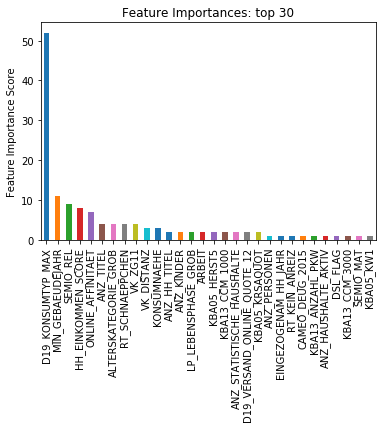

In [233]:
# Re-calibrate # of boosting rounds
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=2,
 scale_pos_weight=1,
 random_state=27)

modelfit(xgb2, X, y)

In [235]:
# Tune subsample and colsample_bytree
# subsample: denotes the fraction of observations to be randomly sampled for each tree: lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
# Typical values: 0.5-1
# colsample_bytree [default=1] : denotes the fraction of columns to be randomly samples for each tree. 
# Typical values: 0.5-1
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=80, max_depth=3,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', n_jobs=2, scale_pos_weight=1, random_state=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=2, iid=False, cv=5)

gsearch4.fit(X, y)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.6925654702032283)

In [237]:
# Fine tune same params as the previous values in the grid were very spread apart
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=80, max_depth=3,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', n_jobs=2, scale_pos_weight=1, random_state=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=2,iid=False, cv=5)

gsearch5.fit(X, y)
gsearch5.best_params_, gsearch5.best_score_

/Users/maurizio/anaconda3/lib/python3.6/site-packages/xgboost/sklearn.py:207: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.6925654702032283)

In [239]:
# Tuning Regularization Parameters: L1 Regularization
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=80, max_depth=3,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', n_jobs=2, scale_pos_weight=1,random_state=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=2, iid=False, cv=5)

gsearch6.fit(X, y)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1}, 0.6941605325613737)

In [240]:
# Fine tune reg_alpha, the previous values were very spread apart

param_test7 = {
 'reg_alpha':[1, 5, 10, 50, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=80, max_depth=3,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', n_jobs=2, scale_pos_weight=1, random_state=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=2, iid=False, cv=5)

gsearch7.fit(X, y)
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 1}, 0.6941605325613737)

[0]	train-auc:0.5+0	test-auc:0.5+0
[10]	train-auc:0.640465+0.0148718	test-auc:0.63819+0.0377739
[20]	train-auc:0.690704+0.0142518	test-auc:0.673957+0.031462
[30]	train-auc:0.735737+0.00681866	test-auc:0.697132+0.0198519
[40]	train-auc:0.756535+0.00348869	test-auc:0.697367+0.0255255
[50]	train-auc:0.776566+0.00262033	test-auc:0.693901+0.0241533
[60]	train-auc:0.797731+0.00292683	test-auc:0.690823+0.0260935
[70]	train-auc:0.817127+0.00396528	test-auc:0.688715+0.0278514
[80]	train-auc:0.835745+0.00262077	test-auc:0.686016+0.0244863

Model Report
AUC Score (Train): 0.741719
CV Result:      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.500000       0.000000       0.500000      0.000000
1         0.500000       0.000000       0.500000      0.000000
2         0.500000       0.000000       0.500000      0.000000
3         0.500000       0.000000       0.500000      0.000000
4         0.500000       0.000000       0.500000      0.000000
5         0.500000       0.000000

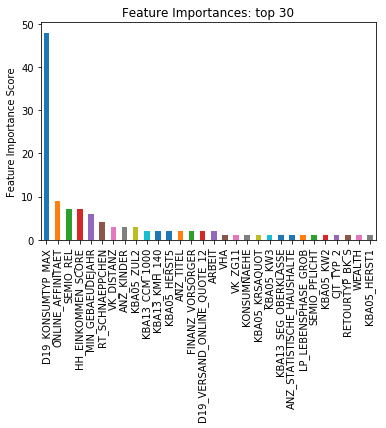

In [241]:
# Apply new parameters to the model
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 n_jobs=2,
 scale_pos_weight=1,
 random_state=27)

modelfit(xgb3, X, y)

[0]	train-auc:0.5+0	test-auc:0.5+0
[10]	train-auc:0.5+0	test-auc:0.5+0
[20]	train-auc:0.653207+0.0206501	test-auc:0.643654+0.0225916
[30]	train-auc:0.681942+0.0133617	test-auc:0.659151+0.029844
[40]	train-auc:0.695391+0.0111378	test-auc:0.667723+0.0317964
[50]	train-auc:0.723361+0.00631808	test-auc:0.682493+0.0305333
[60]	train-auc:0.740834+0.0059641	test-auc:0.694112+0.0268368
[70]	train-auc:0.752766+0.00330029	test-auc:0.698087+0.0243765
[80]	train-auc:0.759326+0.00390672	test-auc:0.695569+0.024827
[90]	train-auc:0.767697+0.00238564	test-auc:0.697745+0.0251164
[100]	train-auc:0.7777+0.00373702	test-auc:0.69564+0.0229362
[110]	train-auc:0.789986+0.00257207	test-auc:0.694176+0.0199517

Model Report
AUC Score (Train): 0.739528
CV Result:      train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.500000       0.000000       0.500000      0.000000
1         0.500000       0.000000       0.500000      0.000000
2         0.500000       0.000000       0.500000      0.000000


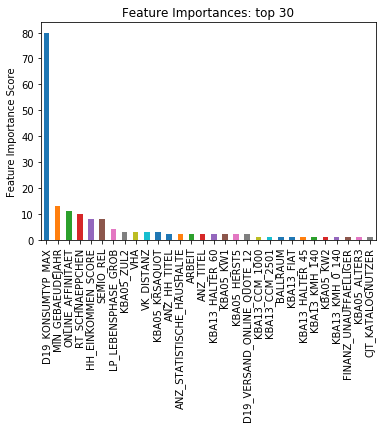

In [244]:
# Reducing  learning rate, increase estimators
xgb4 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'binary:logistic',
 n_jobs=2,
 scale_pos_weight=1,
 random_state=27)

modelfit(xgb4, X, y)

In [ ]:
# And we are done!

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
xgb4.predict